# Applied Data Science Capstone Project

## The Best Places in Frankfurt to Open an Uzbek Restaurant: A Clustering Approach

Bekzod Makhmudov <a href='https://www.linkedin.com/in/bekzod-makhmudov/'>LinkedIn</a>

October 10, 2019

### Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
    * [Neighborhoods and their geographical centers](#neighborhoods)
    * [Distance to the city center](#distance)
    * [Foursquare API - Venues around Neighborhood Center](#foursquare) 
    * [Tripadvisor.com - Top 100 tourist attractions in Frankfurt](#tripadvisor)
    * [Median distances to the top 100 attractions from neighborhood centers](#average)
    * [Descripive Statistics and Regression Analysis](#analysis)
    * [Clustering](#clustering)
* [Results](#results)
* [Conclusion](#conclusion)

### Introduction: Business Problem <a name="introduction"></a>

We are interested in opening an Uzbek restaurant in Frankfurt, which potentially can attract a high number of customers. Ideally, our stakeholders are interested in a **narrowed-down list of potential locations to explore further**. 

The choice of proper locations for an Uzbek restaurant in Frankfurt is very important, because Uzbek cuisine is not widely spread in Frankfurt unlike any other Asian or European cuisines, though it is very popular among European tourists visiting Uzbekistan due to its great potential in gastronomic tourism. Currently, there is only one Uzbek restaurant in Frankfurt and it is located in Wöllstädter Str. 11, 60385 Frankfurt am Main in Bornheim neighborhood.

Our stakeholders point out that a potentially good location for an Uzbek restaurant in Frankfurt should comply to the following criteria:

* Locations close to the city center
* Locations with low restaurant density
* Locations with few or no close Asian restaurants (competitors)
* Locations with high population density
* Locations close to tourist destinations/attractions

Our goal is to come up with a manageable list of optimal locations in Frankfurt that satisfy all of the above criteria.

### Data <a name="data"></a>

According to the criteria that we have defined in our business understanding section, the following factors will influence the choice of optimal locations for an Uzbek restaurant in Frankfurt

* The closer a location to the city center, the better. The city center will be defined at **Hauptwache** (the street is called “An der Hauptwache”). **The distance between a potential location and Hauptwache** will determine the closeness criterion.
* **The number of restaurants** nearby a potential location will be counted towards the **restaurant density**. The less restaurants surround the location, the more suitable it will be.
* **The number of Asian restaurants** surrounding a given location will be counted to determine suitability of a location, as they are close competitors to the Uzbek cuisine. 
* **Neighborhoods with high population density** will be preferable for an optimal location choice, because potentially more customers can be attracted there. 
* Finally, **major tourist attractions** will be taken into account as these places also attract many foreign tourists who can potentially become customers of a nearby Uzbek restaurant.

The following data sources will be used to extract required data:

* Distances from the city center, from the main tourist attractions to potential locations will be obtained using **Google Maps API geocoding and revers geocoding**.
* The names of most popular tourist attractions in Frankfurt will be obtained from **Tripadvisor.com using web scraping** as it does not provide API access for data analysis purposes.
* The number of restaurants, their category and type as well as their geolocation information will be obtained through **Foursquare API**.
* The names of the neighbourhoods in Frankfurt and their population density will be obtained **using web scraping from Wikipedia** at https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main.


### Methodology <a name="methodology"></a>

### Neighborhoods and their geographical centers<a name="neighborhoods"></a>

Firstly, I will get the names of the neighborhoods, identify their geographical centers and display them on the map of Frankfurt.

In [110]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

source = requests.get('https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main').text

soup = BeautifulSoup(source, 'lxml')

# Neighborhood names
neighborhoods = []
for cell in soup.find_all('td'):
    try:
        table_neighborhood = cell.p.text
        table_neighborhood = table_neighborhood.strip('\n')
        neighborhoods.append(table_neighborhood)
    except:
        pass

# removing row containing Airport
del neighborhoods[14] 

# Change the names conaining 'Süd' and 'Nord' to distinguishable locations for Google Map
neighborhoods[3] = 'Westend-South'
neighborhoods[4] = 'Westend-North'
neighborhoods[12] = 'Sachsenhausen-N'
neighborhoods[13] = 'Sachsenhausen-S'
print('Number of neighborhoods is', len(neighborhoods))
print('First five names of the neighborhoods:', neighborhoods[:5])

# Population density of each neighborhood
population_density = []
for cell in soup.find_all('td'):
    try:
        density = cell.text
        density = density.strip('\n')
        population_density.append(density)
    except:
        pass

del population_density[182:189] #removing information on Airport

population_density = population_density[9:584:13]
print('Number of data points on population density is', len(population_density))
print('First five data points on population density:', population_density[:5])


Number of neighborhoods is 45
First five names of the neighborhoods: ['Altstadt', 'Innenstadt', 'Bahnhofsviertel', 'Westend-South', 'Westend-North']
Number of data points on population density is 45
First five data points on population density: ['8187', '4430', '6558', '7550', '6249']


In [112]:
data_table = {'Neighborhood':[x for x in neighborhoods], 'Population density':[x for x in population_density]}
df = pd.DataFrame(data_table)
df.head()

,Neighborhood,Population density
0,Altstadt,8187
1,Innenstadt,4430
2,Bahnhofsviertel,6558
3,Westend-South,7550
4,Westend-North,6249


In [1]:
google_api_key = '' # Intentionally left blank

In [115]:
# Geolocational data from Google Map API
## Geolocational data for Frankfurt

address = 'Frankfurt, Germany'
url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, address)
response = requests.get(url).json()
geo_data = response['results'][0]['geometry']['location']
lat_Frankfurt = geo_data['lat']
lon_Frankfurt = geo_data['lng']
print('Geolocational data for Frankfurt: Latitude {}, Longitude {}'.format(lat_Frankfurt, lon_Frankfurt))

## Geolocational data for neighborhoods
neigh_lat_lon = {'Neighborhood':[],'Latitude':[],'Longitude':[]}
for item in neighborhoods:
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, item+', Frankfurt, Germany')
        response = requests.get(url).json()
        geo_data = response['results'][0]['geometry']['location']
        latitude = geo_data['lat']
        longitude = geo_data['lng']
        neigh_lat_lon['Latitude'].append(latitude)
        neigh_lat_lon['Longitude'].append(longitude)
        neigh_lat_lon['Neighborhood'].append(item)
    except:
        neigh_lat_lon['Latitude'].append(None)
        neigh_lat_lon['Longitude'].append(None)
        neigh_lat_lon['Neighborhood'].append(item)
        print(item, end='...None\n')
print('Complete')

Geolocational data for Frankfurt: Latitude 50.1109221, Longitude 8.6821267
Complete


In [122]:
!pip install folium
import folium

# Visualization of districts on Frankfurt map
map_frankfurt = folium.Map(location=[lat_Frankfurt, lon_Frankfurt], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_geo_neighborhood['Latitude'], df_geo_neighborhood['Longitude'], df_geo_neighborhood['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

In [123]:
# merging two tables 
df_table = pd.merge(df_geo_neighborhood, df, on='Neighborhood')

In [124]:
df_table.head()

,Neighborhood,Latitude,Longitude,Population density
0,Altstadt,50.110090,8.682249,8187
1,Innenstadt,50.110659,8.675272,4430
2,Bahnhofsviertel,50.109103,8.669522,6558
3,Westend-South,50.111048,8.663685,7550
4,Westend-North,50.114932,8.658700,6249


In [125]:
df_table['Population density'] = df_table['Population density'].astype(int)

In [134]:
df_table.head(15)

,Neighborhood,Latitude,Longitude,Population density
0,Altstadt,50.110090,8.682249,8187
1,Innenstadt,50.110659,8.675272,4430
2,Bahnhofsviertel,50.109103,8.669522,6558
3,Westend-South,50.111048,8.663685,7550
4,Westend-North,50.114932,8.658700,6249
5,Nordend-West,50.129437,8.683283,9845
6,Nordend-Ost,50.127075,8.697468,15031
7,Ostend,50.111546,8.705952,5246
8,Bornheim,50.130918,8.708847,10959
9,Gutleutviertel,50.099379,8.652440,3147


### Distance to the city center<a name="distance"></a>

After getting the names of the neighborhoods in Frankfurt (45 neighborhoods instead of 46, since Airport as a separate neighborhood is exlcuded from our list) and obtaining their geolocational coordinates, I will proceed to determine the **geographical centers** for each neighborhood, which will consist of **latitude and longitude** as well as a **precise street name**. I will do that using <u>Google Map API geocoding and reverse geocoding</u>.  The decision to choose a geographical center rather than a popular neighborhood center is performed for exploratory reasons and for getting initial insights about the neighborhoods. This can be changed according to the requirements of stakeholders.

In [131]:
# Getting latitude and longitude of the city center
address = 'An der Hauptwache, Frankfurt, Germany'
url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, address)
response = requests.get(url).json()
geo_data = response['results'][0]['geometry']['location']
lat_Hauptwache = geo_data['lat']
lon_Hauptwache = geo_data['lng']

print('Geolocational data for Hauptwache: Latitude {}, Longitude {}'.format(lat_Hauptwache, lon_Hauptwache))

Geolocational data for Hauptwache: Latitude 50.1140696, Longitude 8.6787681


In [132]:
# Obtain distances between a neighborhood and the city center
distance_to_center = {'Neighborhood':[],'Distance to city center':[],'Neighborhood center':[]}

for i in range(45):
    try:
        origin = '{},{}'.format(df_table.loc[i,'Latitude'],df_table.loc[i,'Longitude'])
        destination = '{},{}'.format(lat_Hauptwache,lon_Hauptwache)
        url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins={}&destinations={}&key={}'.format(origin, destination, google_api_key)
        distance = requests.get(url).json()['rows'][0]['elements'][0]['distance']['value']
        neighborhood_center = requests.get(url).json()['origin_addresses'][0]
        distance_to_center['Distance to city center'].append(distance)
        distance_to_center['Neighborhood center'].append(neighborhood_center)
        name = df_table.loc[i,'Neighborhood']
        distance_to_center['Neighborhood'].append(name)
    except:
        distance_to_center['Distance to city center'].append(None)
        distance_to_center['Neighborhood center'].append(None)
        name = df_table.loc[i,'Neighborhood']
        distance_to_center['Neighborhood'].append(name)
        print(name, '...None.')
        
print('Complete.')

Complete.


In [133]:
df_distance_to_center = pd.DataFrame(distance_to_center)
df_distance_to_center.head(15)

,Neighborhood,Distance to city center,Neighborhood center
0,Altstadt,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany"
1,Innenstadt,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G..."
2,Bahnhofsviertel,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,..."
3,Westend-South,2323,"Mainzer Landstraße 50, 60325 Frankfurt am Main..."
4,Westend-North,2567,"Arndtstraße 9, 60325 Frankfurt am Main, Germany"
5,Nordend-West,1951,"Oeder Weg 153, 60318 Frankfurt am Main, Germany"
6,Nordend-Ost,2880,"Rothschildallee 20, 60389 Frankfurt am Main, G..."
7,Ostend,3160,"Hanauer Landstraße 89, 60314 Frankfurt am Main..."
8,Bornheim,4065,"Im Prüfling 63, 60389 Frankfurt am Main, Germany"
9,Gutleutviertel,3979,"Gutleutstraße 231, 60327 Frankfurt am Main, Ge..."


In [135]:
# Performing editing due to inaccuracies in converting address names to geocoding information 
df_distance_to_center.loc[14,'Neighborhood center']='Buchrainplatz, Frankfurt, Germany'
df_distance_to_center.loc[3,'Neighborhood center']='Bockenheimer Landstraße 69, 60325 Frankfurt am Main, Germany'
df_distance_to_center.loc[4,'Neighborhood center']='Siolistraße 8, 60323 Frankfurt am Main, Germany'

In [137]:
# merging two tables 
df_table_3 = pd.merge(df_table, df_distance_to_center, on='Neighborhood')

In [138]:
df_table_3.head()

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany"
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G..."
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,..."
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am..."
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany"


In [141]:
# Getting Neighborhood center geolocational information (latitudes and longitues) from address names
neighborhood_center_geo = {'Neighborhood':[],'Neighborhood center latitude':[],'Neighborhood center longitude':[]}
for i in range(45):
    try:
        address = df_table_3.loc[i,'Neighborhood center']
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, address)
        response = requests.get(url).json()
        geo_data = response['results'][0]['geometry']['location']
        lat_center = geo_data['lat']
        lon_center = geo_data['lng']
        neighborhood_center_geo['Neighborhood center latitude'].append(lat_center)
        neighborhood_center_geo['Neighborhood center longitude'].append(lon_center)
        name = df_table.loc[i,'Neighborhood']
        neighborhood_center_geo['Neighborhood'].append(name)
    except:
        neighborhood_center_geo['Neighborhood center latitude'].append(None)
        neighborhood_center_geo['Neighborhood center longitude'].append(None)
        name = df_table.loc[i,'Neighborhood']
        neighborhood_center_geo['Neighborhood'].append(name)
        print(name,'...None.')

print('Complete.')

Complete.


In [142]:
df_neighborhood_center_geo = pd.DataFrame(neighborhood_center_geo)
df_neighborhood_center_geo.head()

,Neighborhood,Neighborhood center latitude,Neighborhood center longitude
0,Altstadt,50.110190,8.682590
1,Innenstadt,50.110491,8.675284
2,Bahnhofsviertel,50.109080,8.669550
3,Westend-South,50.118140,8.662130
4,Westend-North,50.129383,8.666920


In [145]:
# merging two tables 
df_table_4 = pd.merge(df_table_3, df_neighborhood_center_geo, on='Neighborhood')

In [146]:
df_table_4.head()

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center,Neighborhood center latitude,Neighborhood center longitude
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany",50.110190,8.682590
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",50.110491,8.675284
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",50.109080,8.669550
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",50.118140,8.662130
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany",50.129383,8.666920


### Foursquare API - Venues around Neighborhood Centers<a name="foursquare"></a>

After obtaining the information about the “neighborhood centers”, I will explore <b>the number of restaurants in the radius of 500 m around each neighborhood center</b> using <u>Foursquare API</u>. Choosing the radius of 500 m was done for exploratory reasons and it is meant to be a reasonable area around each neighborhood center to analyze the level of competition. Furthermore, among these restaurants within the radius **the number of Asian restaurants** will be of particular interest because they are considered to the main competitors for an Uzbek cuisine. It is important to note that **only category “restaurant” will be considered**, and all the other food venues will be ignored in order to produce a consistent analysis.

In [151]:
CLIENT_ID = '' # Intentionally left blank
CLIENT_SECRET = '' # Intentionally left blank
VERSION = '20191001'

In [153]:
# Setting up function to get information on nearby venues using Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,  
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['location']['distance']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Distance to Venue']
    
    return(nearby_venues)

In [155]:
# Using the function to obtain venue information around neighborhood centers
frankfurt_venues = getNearbyVenues(names = df_table_4['Neighborhood'],
                                   latitudes = df_table_4['Neighborhood center latitude'],
                                   longitudes = df_table_4['Neighborhood center longitude'],
                                   radius=500)
print('Complete')

Complete


In [157]:
# Filtering out all venues based on their category containing the word 'Restaurant'
venue_restaurants = frankfurt_venues[frankfurt_venues['Venue Category'].str.contains('Restaurant')]
venue_restaurants.reset_index(inplace=True)
venue_restaurants.drop(['index'], axis=1,inplace=True)
venue_restaurants.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Venue
0,Altstadt,Paulaner am Dom,50.110876,8.685925,German Restaurant,250
1,Altstadt,Fisch Franke,50.112252,8.684247,Seafood Restaurant,258
2,Altstadt,Superkato,50.111664,8.679153,Sushi Restaurant,295
3,Altstadt,Heimat – Essen und Weine,50.111125,8.678286,German Restaurant,324
4,Altstadt,Góc Phố,50.113509,8.681686,Vietnamese Restaurant,375


In [172]:
print('Total of {} venues'.format(len(venue_restaurants['Venue'])))
print('Total of {} unique venues'.format(len(venue_restaurants['Venue'].unique())))

Total of 186 venues
Total of 182 unique venues


In [173]:
# Setting up a list of competitor restaurant categories to an Uzbek restaurant
competitor_categories = ['Asian Restaurant',
                         'Doner Restaurant',
                         'Kebab Restaurant',
                         'Middle Eastern Restaurant',
                         'Persian Restaurant',
                         'Turkish Restaurant']

In [174]:
# Generating a table with competitor venue names and geolocational information
competitor_table = venue_restaurants[venue_restaurants['Venue Category'] == competitor_categories[0]]

for i in range(1,6):
    table = venue_restaurants[venue_restaurants['Venue Category'] == competitor_categories[i]]
    competitor_table = competitor_table.append(table)

competitor_table

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Venue
26,Bahnhofsviertel,COA - Asian food,50.108085,8.666420,Asian Restaurant,249
45,Nordend-West,Sampan,50.125930,8.685915,Asian Restaurant,421
47,Nordend-West,Mr. Thai Express,50.131733,8.684439,Asian Restaurant,278
90,Gallus,Mei Mei Chinapoint,50.102821,8.641377,Asian Restaurant,220
96,Gallus,Asia Wok & Express,50.101543,8.640555,Asian Restaurant,374
98,Bockenheim,Mai Vien,50.118236,8.644628,Asian Restaurant,134
103,Bockenheim,Thai Wok,50.119278,8.640219,Asian Restaurant,221
132,Niederrad,Mai Fresh,50.086842,8.645956,Asian Restaurant,385
136,Griesheim,Asia Restaurant Hahaa,50.100005,8.596791,Asian Restaurant,399
154,Ginnheim,Sanmaru Restaurant und Hotel,50.142011,8.647792,Asian Restaurant,58


In [175]:
# Counting competitor venues based on category
competitor_table.groupby('Venue Category').count()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Distance to Venue
Venue Category,,,,,
Asian Restaurant,12,12,12,12,12
Doner Restaurant,4,4,4,4,4
Kebab Restaurant,1,1,1,1,1
Middle Eastern Restaurant,1,1,1,1,1
Persian Restaurant,1,1,1,1,1
Turkish Restaurant,5,5,5,5,5


In [176]:
!pip install folium
import folium

# Visualization of districts and competitors on Frankfurt map
map_frankfurt = folium.Map(location=[lat_Frankfurt, lon_Frankfurt], zoom_start=11)

# add neighborhood markers to map
group0 = folium.FeatureGroup(name='Neighborhoods')
for lat, lng, label in zip(df_table_4['Latitude'], df_table_4['Longitude'], df_table_4['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(group0)  
group0.add_to(map_frankfurt)

# add competitor markers to map
group1 = folium.FeatureGroup(name='Competitors')
for lat, lng, label in zip(competitor_table['Venue Latitude'], competitor_table['Venue Longitude'], competitor_table['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(group1)
group1.add_to(map_frankfurt)

folium.map.LayerControl('topright', collapsed=False).add_to(map_frankfurt)

map_frankfurt    

In [179]:
# Seperating competitor and non-competitor restaurants into two columns
neighborhood_restaurant_number = {'Neighborhood':[],'Competitor':[],'Not competitor':[]}

for i in range(186):
    name = venue_restaurants.loc[i,'Neighborhood']
    if venue_restaurants.loc[i,'Venue Category'] in competitor_categories:
        neighborhood_restaurant_number['Neighborhood'].append(name)
        competitor = venue_restaurants.loc[i,'Venue']
        neighborhood_restaurant_number['Competitor'].append(competitor)
        neighborhood_restaurant_number['Not competitor'].append(None)
    else:
        neighborhood_restaurant_number['Neighborhood'].append(name)
        not_competitor = venue_restaurants.loc[i,'Venue']
        neighborhood_restaurant_number['Competitor'].append(None)
        neighborhood_restaurant_number['Not competitor'].append(not_competitor)
print('Done')

Done


In [180]:
df_neighborhood_restaurants = pd.DataFrame(neighborhood_restaurant_number)
df_neighborhood_restaurants.head()

,Neighborhood,Competitor,Not competitor
0,Altstadt,None,Paulaner am Dom
1,Altstadt,None,Fisch Franke
2,Altstadt,None,Superkato
3,Altstadt,None,Heimat – Essen und Weine
4,Altstadt,None,Góc Phố


In [182]:
# Mergin obtained information on competitors with the main table
df_table_5 = pd.merge(df_table_4, competitor_count, on='Neighborhood', how='left')
df_table_5.head(15)

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center,Neighborhood center latitude,Neighborhood center longitude,Competitor,Not competitor
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany",50.110190,8.682590,0.0,7.0
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",50.110491,8.675284,0.0,8.0
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",50.109080,8.669550,1.0,11.0
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",50.118140,8.662130,0.0,14.0
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany",50.129383,8.666920,NaN,NaN
5,Nordend-West,50.129437,8.683283,9845,1951,"Oeder Weg 153, 60318 Frankfurt am Main, Germany",50.129333,8.683328,2.0,7.0
6,Nordend-Ost,50.127075,8.697468,15031,2880,"Rothschildallee 20, 60389 Frankfurt am Main, G...",50.127195,8.697220,1.0,8.0
7,Ostend,50.111546,8.705952,5246,3160,"Hanauer Landstraße 89, 60314 Frankfurt am Main...",50.111893,8.705876,0.0,10.0
8,Bornheim,50.130918,8.708847,10959,4065,"Im Prüfling 63, 60389 Frankfurt am Main, Germany",50.130877,8.708569,1.0,12.0
9,Gutleutviertel,50.099379,8.652440,3147,3979,"Gutleutstraße 231, 60327 Frankfurt am Main, Ge...",50.099271,8.653199,0.0,5.0


In [184]:
# Adding additional column to the main table with total number of restaurants
df_table_5['Total restaurants'] = df_table_5[['Competitor','Not competitor']].sum(axis=1)

In [185]:
df_table_5.head()

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center,Neighborhood center latitude,Neighborhood center longitude,Competitor,Not competitor,Total restaurants
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany",50.110190,8.682590,0.0,7.0,7.0
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",50.110491,8.675284,0.0,8.0,8.0
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",50.109080,8.669550,1.0,11.0,12.0
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",50.118140,8.662130,0.0,14.0,14.0
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany",50.129383,8.666920,NaN,NaN,0.0


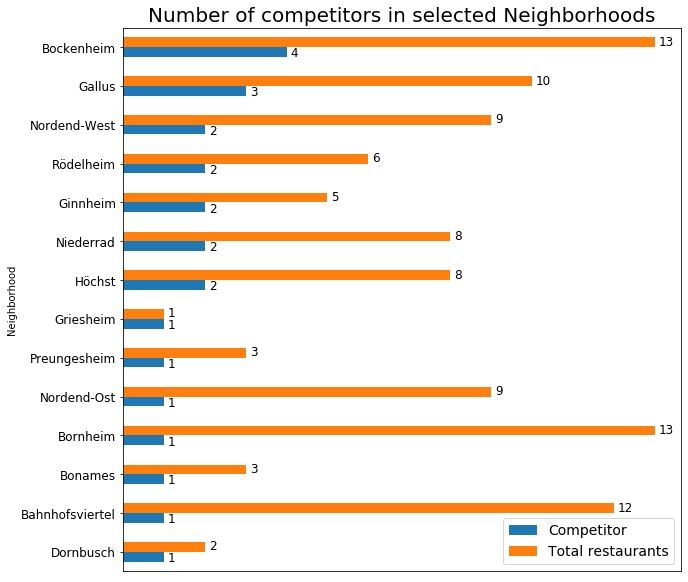

In [202]:
# Generating list of cmpetitors and displaying them on a bar chart
competitors = df_table_5.groupby('Neighborhood').sum().sort_values(by='Competitor', 
                                                                   ascending=True).tail(14)[['Competitor','Total restaurants']]
ax = competitors.plot(kind='barh', figsize=(10,10),fontsize=12)
ax.set_title("Number of competitors in selected Neighborhoods", fontsize=20)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
#Annotations
for index,value in enumerate(competitors['Competitor']):
    ax.annotate(round(value), xy=(value+0.1, index - 0.25), fontsize=12)
for index,value in enumerate(competitors['Total restaurants']):
    ax.annotate(round(value), xy=(value+0.1, index + 0.05), fontsize=12)

### Tripadvisor.com - Top 100 tourist attractions in Frankfurt <a name='tripadvisor'></a>

Next, the names of **top 100 tourist attractions in Frankfurt** will be obtained from <u>Tripadvisor.com</u> and their geolocational coordinates (longitude and latitude) will be identified using <u>Google Map geocoding API</u>. This geolocational information will be used to calculate **the average distance between a neighborhood center to these tourist attractions**, which will give us insight on how close each neighborhood is on average to the main tourist destinations.

In [188]:
# Getting the list of top 100 attractions from tripadvisor.com
# 1st 30 attractions
url1 = 'https://www.tripadvisor.com/Attractions-g187337-Activities-a_allAttractions.true-Frankfurt_Hesse.html'
# 2nd 30 attractions
url2 = 'https://www.tripadvisor.com/Attractions-g187337-Activities-oa30-Frankfurt_Hesse.html#FILTERED_LIST'
# 3rd 30 attractions
url3 = 'https://www.tripadvisor.com/Attractions-g187337-Activities-oa60-Frankfurt_Hesse.html#FILTERED_LIST'
# 4th 30 attractions
url4 = 'https://www.tripadvisor.com/Attractions-g187337-Activities-oa90-Frankfurt_Hesse.html#FILTERED_LIST'

urls = [url1,url2,url3,url4]
attractions = []

for url in urls:
    source = requests.get(url).text
    soup = BeautifulSoup(source, 'lxml')
    for cell in soup.find_all('div', class_='tracking_attraction_title'):
        try:
            table_attraction = cell.a.text
            attractions.append(table_attraction)
        except:
            pass
print('Done.')


Done.


In [189]:
len(attractions)

120

In [190]:
# Getting geolocational information of top 100 attractions from Google Map API
attraction_geodata = {'Attraction':[],'Attraction latitude':[],'Attraction longitude':[]}

for attraction in attractions[:101]:
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, attraction+', Frankfurt, Germany')
        response = requests.get(url).json()
        geo_data = response['results'][0]['geometry']['location']
        attraction_lat = geo_data['lat']
        attraction_lon = geo_data['lng']
        attraction_geodata['Attraction latitude'].append(attraction_lat)
        attraction_geodata['Attraction longitude'].append(attraction_lon)
        attraction_geodata['Attraction'].append(attraction)
    except:
        attraction_geodata['Attraction latitude'].append(None)
        attraction_geodata['Attraction longitude'].append(None)
        attraction_geodata['Attraction'].append(attraction)
        print(attraction,'...None.')
print('Complete')

Dialog Museum ...None.
Complete


In [191]:
len(set(attraction_geodata['Attraction']))

101

In [192]:
df_attraction_geodata = pd.DataFrame(attraction_geodata)
df_attraction_geodata.head()

,Attraction,Attraction latitude,Attraction longitude
0,Stadel Museum,50.103093,8.674058
1,Main Tower,50.112493,8.672167
2,Palmengarten,50.123185,8.657854
3,Romer,50.110424,8.681576
4,Senckenberg Natural History Museum (Naturmuseu...,50.117540,8.651706


In [197]:
# Removing one attracton called 'Dialog Museum' for which there are not geocoding data
df_attraction_geodata.drop(25,axis=0,inplace=True) # 'Dialog Museum' is located on row index 25
df_attraction_geodata.reset_index(inplace=True)
df_attraction_geodata.drop('index',axis=1,inplace=True)
df_attraction_geodata.shape

(100, 3)

In [199]:
df_attraction_geodata.head()

,Attraction,Attraction latitude,Attraction longitude
0,Stadel Museum,50.103093,8.674058
1,Main Tower,50.112493,8.672167
2,Palmengarten,50.123185,8.657854
3,Romer,50.110424,8.681576
4,Senckenberg Natural History Museum (Naturmuseu...,50.117540,8.651706


In [200]:
!pip install folium
import folium

# Visualization of attractions on Frankfurt map
map_frankfurt = folium.Map(location=[lat_Frankfurt, lon_Frankfurt], zoom_start=11)

# add neighborhood markers to map
group0 = folium.FeatureGroup(name='Neighborhoods')
for lat, lng, label in zip(df_table_4['Latitude'], df_table_4['Longitude'], df_table_4['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(group0)  
group0.add_to(map_frankfurt)

# add markers to map
group3 = folium.FeatureGroup(name='Attractions')
for lat, lng, label in zip(df_attraction_geodata['Attraction latitude'], df_attraction_geodata['Attraction longitude'], df_attraction_geodata['Attraction']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#cf1bb4',
        fill=True,
        fill_color='#cf1bb4',
        fill_opacity=0.7,
        parse_html=False).add_to(group3)  
group3.add_to(map_frankfurt)    

folium.map.LayerControl('topright', collapsed=False).add_to(map_frankfurt)
   
map_frankfurt

### Median distances to the top 100 attractions from neighborhood centers<a name='average'></a>

In [204]:
# Obtain distances between a neighborhood and attractions
distance_to_attraction = {'Neighborhood':[],'Distance to attraction':[],'Attraction':[]}

for i in range(45):
    center = '{},{}'.format(df_table_5.loc[i,'Neighborhood center latitude'],df_table_5.loc[i,'Neighborhood center longitude'])
    name_neighborhood = df_table_5.loc[i,'Neighborhood']
    for j in range(100):
        name_attraction = df_attraction_geodata.loc[j,'Attraction']
        try:
            attraction = '{},{}'.format(df_attraction_geodata.loc[j,'Attraction latitude'],df_attraction_geodata.loc[j,'Attraction longitude'])
            url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins={}&destinations={}&key={}'.format(center, attraction, google_api_key)
            distance = requests.get(url).json()['rows'][0]['elements'][0]['distance']['value']
            distance_to_attraction['Distance to attraction'].append(distance)
            distance_to_attraction['Attraction'].append(name_attraction)
            distance_to_attraction['Neighborhood'].append(name_neighborhood)
        except:
            distance_to_attraction['Distance to attraction'].append(None)
            distance_to_attraction['Attraction'].append(name_attraction)
            distance_to_attraction['Neighborhood'].append(name_neighborhood)
            print(name_attraction, '...None.')
        
print('Complete.')

Complete.


In [205]:
df_distance_to_attractions = pd.DataFrame(distance_to_attraction)
df_distance_to_attractions.shape

(4500, 3)

In [210]:
# Calculating median distance of each attraction to all 100 attractions
median_distance_to_attractions = df_distance_to_attractions.groupby('Neighborhood').median()
median_distance_to_attractions.rename(columns={'Distance to attraction':'Median distance to attractions'}, inplace=True)
median_distance_to_attractions

,Median distance to attractions
Neighborhood,
Altstadt,2424.0
Bahnhofsviertel,2405.5
Bergen-Enkheim,11871.0
Berkersheim,9186.5
Bockenheim,3967.5
Bonames,10026.5
Bornheim,4500.5
Dornbusch,5957.0
Eckenheim,5915.5


In [211]:
#Mergin this information with the main table
df_final_table = pd.merge(df_table_5,median_distance_to_attractions, on='Neighborhood')
df_final_table.head()

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center,Neighborhood center latitude,Neighborhood center longitude,Competitor,Not competitor,Total restaurants,Median distance to attractions
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany",50.110190,8.682590,0.0,7.0,7.0,2424.0
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",50.110491,8.675284,0.0,8.0,8.0,1811.5
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",50.109080,8.669550,1.0,11.0,12.0,2405.5
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",50.118140,8.662130,0.0,14.0,14.0,2500.0
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany",50.129383,8.666920,NaN,NaN,0.0,3575.0


In [214]:
#Replacing NaN values with 0 in competitor and non-competitor columns
df_final_table['Competitor'].fillna(0,inplace=True)
df_final_table['Not competitor'].fillna(0,inplace=True)
df_final_table.head()

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center,Neighborhood center latitude,Neighborhood center longitude,Competitor,Not competitor,Total restaurants,Median distance to attractions
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany",50.110190,8.682590,0.0,7.0,7.0,2424.0
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",50.110491,8.675284,0.0,8.0,8.0,1811.5
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",50.109080,8.669550,1.0,11.0,12.0,2405.5
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",50.118140,8.662130,0.0,14.0,14.0,2500.0
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany",50.129383,8.666920,0.0,0.0,0.0,3575.0


### Descripive Statistics and Regression Analysis<a name='analysis'></a>

In [217]:
# Generating descriptive statistics for five key features
neighborhood_features = ['Population density','Distance to city center','Competitor','Total restaurants','Median distance to attractions']
df_final_table[neighborhood_features].describe()

,Population density,Distance to city center,Competitor,Total restaurants,Median distance to attractions
count,45.000000,45.000000,45.000000,45.000000,45.000000
mean,4792.755556,7818.088889,0.533333,4.133333,8121.600000
std,3043.431296,4772.231034,0.943880,4.459923,4691.811875
min,564.000000,1698.000000,0.000000,0.000000,1811.500000
25%,2512.000000,4063.000000,0.000000,1.000000,3967.500000
50%,4644.000000,6795.000000,0.000000,2.000000,7381.000000
75%,6384.000000,9376.000000,1.000000,8.000000,10274.500000
max,15031.000000,22428.000000,4.000000,14.000000,19858.500000


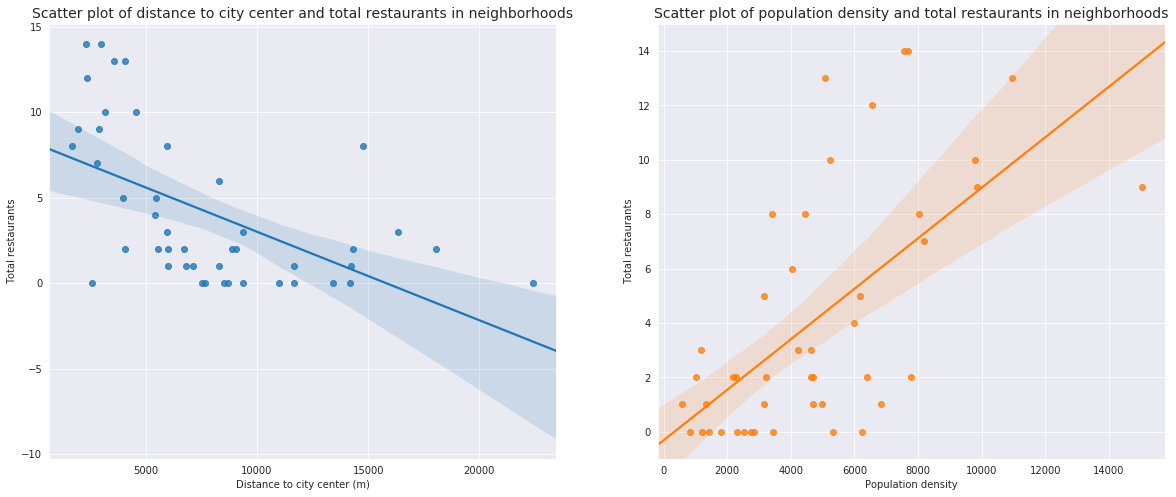

In [231]:
# Fitting regression line on five key variables
import seaborn as sns

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


sns.regplot(x='Distance to city center',y='Total restaurants',data=df_final_table, ax=ax1)
ax1.set(xlabel='Distance to city center (m)',ylabel='Total restaurants')
ax1.set_title('Scatter plot of distance to city center and total restaurants in neighborhoods',fontsize=14)


sns.regplot(x='Population density',y='Total restaurants',data=df_final_table, ax=ax2)
ax2.set(xlabel='Population density',ylabel='Total restaurants')
ax2.set_title('Scatter plot of population density and total restaurants in neighborhoods',fontsize=14)
ax2.set(ylim=(-1, 15))

plt.show()

In [232]:
# Calculation of correlation coefficients and p-values of linear regression
from scipy import stats
def r(x,y):
    r,p = stats.pearsonr(x, y)
    return r
def p(x,y):
    r,p = stats.pearsonr(x, y)
    return p
print('Calculation of correlation coefficients and p-values')
print('---------------------------------------------')
x1=df_final_table['Distance to city center']
y1=df_final_table['Total restaurants']
print('Distance to city center and total restaurants')
print("r = " + str(round(r(x1,y1),3)))
print('p = ' + str(round(p(x1,y1),4)))
print('---------------------------------------------')
x2=df_final_table['Population density']
y2=df_final_table['Total restaurants']
print('Population density and total restaurants')
print("r = " + str(round(r(x2,y2),3)))
print('p = ' + str(round(p(x2,y2),4)))

Calculation of correlation coefficients and p-values
---------------------------------------------
Distance to city center and total restaurants
r = -0.554
p = 0.0001
---------------------------------------------
Population density and total restaurants
r = 0.634
p = 0.0


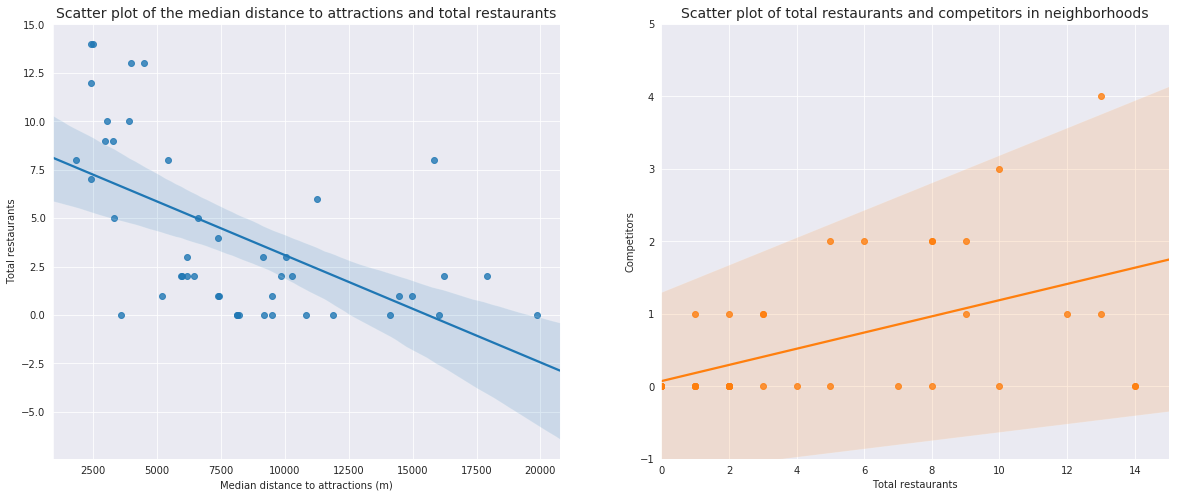

In [233]:
# Fitting regression line on five key variables
import seaborn as sns
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


sns.regplot(x='Median distance to attractions',y='Total restaurants',data=df_final_table, ax=ax1)
ax1.set(xlabel='Median distance to attractions (m)',ylabel='Total restaurants')
ax1.set_title('Scatter plot of the median distance to attractions and total restaurants',fontsize=14)

sns.regplot(x='Total restaurants',y='Competitor',data=df_final_table, ax=ax2)
ax2.set(xlabel='Total restaurants',ylabel='Competitors')
ax2.set_title('Scatter plot of total restaurants and competitors in neighborhoods',fontsize=14)
ax2.set(ylim=(-1, 5))
ax2.set(xlim=(0, 15))

plt.show()

In [234]:
# Calculation of correlation coefficients and p-values of linear regression
from scipy import stats
def r(x,y):
    r,p = stats.pearsonr(x, y)
    return r
def p(x,y):
    r,p = stats.pearsonr(x, y)
    return p
print('Calculation of correlation coefficients and p-values')
print('---------------------------------------------')
x1=df_final_table['Median distance to attractions']
y1=df_final_table['Total restaurants']
print('Median distance to attractions and total restaurants')
print("r = " + str(round(r(x1,y1),3)))
print('p = ' + str(round(p(x1,y1),4)))
print('---------------------------------------------')
x2=df_final_table['Total restaurants']
y2=df_final_table['Competitor']
print('Total restaurants and competitors')
print("r = " + str(round(r(x2,y2),3)))
print('p = ' + str(round(p(x2,y2),4)))

Calculation of correlation coefficients and p-values
---------------------------------------------
Median distance to attractions and total restaurants
r = -0.582
p = 0.0
---------------------------------------------
Total restaurants and competitors
r = 0.528
p = 0.0002


### Clustering <a name='clustering'></a>

I will proceed to cluster neighborhood center according to the following 5 features:
- Distance to the city center
- Average distance to the top 100 tourist attractions
- The number of restaurants within 500 m radius around the neighborhood center
- The number of Asian restaurants within 500 m radius around the neighborhood center
- Population density of a neighborhood.

I will use **k-Means clustering algorithm** because this is a widely applied method to cluster items based on their similarity. I will apply <u>Python’s Scikit-learn library</u> to identify clusters. I will also use **Elbow method** to determine an optimal number of clusters using sum of squared errors method. To give an equal weight to the numerical features, I will use **standard scaling method** to prepare the data for clustering analysis.

The purpose of using clustering of neighborhoods is to get insights about the nature of neighborhoods in terms of the five features and try to reveal commonalities of neighborhoods within each cluster. **This will help me to preselect neighborhoods in the most suitable cluster and provide a finalized list of potential locations (neighborhood centers) to open an Uzbek restaurant in Frankfurt**.

In [218]:
# I create a dataset with five neighborhood features
X = df_final_table[neighborhood_features]
X = X.values

In [219]:
# Scaling values in five variables using StandardScaler
from sklearn.preprocessing import StandardScaler
X_standard = StandardScaler().fit_transform(X)
X_standard[:5]

array([[ 1.12787127, -1.06509568, -0.57142857,  0.65002461, -1.22809308],
       [-0.12053981, -1.29692896, -0.57142857,  0.87677738, -1.36011481],
       [ 0.58657192, -1.15176827,  0.5       ,  1.78378846, -1.23208068],
       [ 0.91620295, -1.16448307, -0.57142857,  2.237294  , -1.21171161],
       [ 0.48389451, -1.1127762 , -0.57142857, -0.93724479, -0.98      ]])

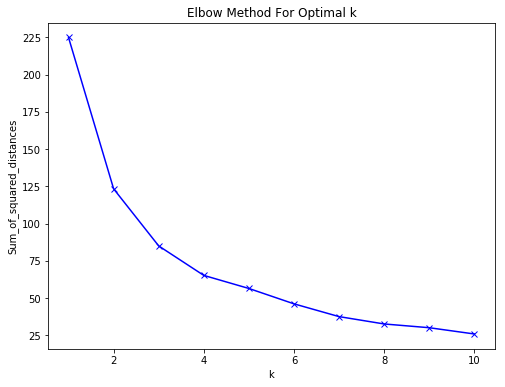

In [220]:
# Determine optimal number of clusters using Elbow method
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    km = kmeans.fit(X_standard)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

According to the Elbow method, the optimal number of clusters is **k = 4**.

In [221]:
# Fitting my clustering model with 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_standard)
labels = kmeans.labels_

### Results <a name='results'></a>

In [222]:
# I add Cluster labels column into my final table
df_final_table['Cluster labels'] = labels
df_final_table.head()

,Neighborhood,Latitude,Longitude,Population density,Distance to city center,Neighborhood center,Neighborhood center latitude,Neighborhood center longitude,Competitor,Not competitor,Total restaurants,Median distance to attractions,Cluster labels
0,Altstadt,50.110090,8.682249,8187,2792,"Römerberg 16, 60311 Frankfurt am Main, Germany",50.110190,8.682590,0.0,7.0,7.0,2424.0,3
1,Innenstadt,50.110659,8.675272,4430,1698,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",50.110491,8.675284,0.0,8.0,8.0,1811.5,3
2,Bahnhofsviertel,50.109103,8.669522,6558,2383,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",50.109080,8.669550,1.0,11.0,12.0,2405.5,3
3,Westend-South,50.111048,8.663685,7550,2323,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",50.118140,8.662130,0.0,14.0,14.0,2500.0,3
4,Westend-North,50.114932,8.658700,6249,2567,"Siolistraße 8, 60323 Frankfurt am Main, Germany",50.129383,8.666920,0.0,0.0,0.0,3575.0,0


In [239]:
import folium

# Visualization of clusters on Frankfurt map
map_frankfurt = folium.Map(location=[lat_Frankfurt, lon_Frankfurt], zoom_start=11)

cluster_color=['red','blue','green','brown']

# add markers to map
for lat, lng, cluster, label in zip(df_final_table['Latitude'], df_final_table['Longitude'], df_final_table['Cluster labels'],df_final_table['Neighborhood']):
    label = folium.Popup(html='{}, cluster {}'.format(label,cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cluster_color[cluster],
        fill=True,
        fill_color=cluster_color[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)
    

map_frankfurt

In [241]:
# Generating mean values for five key variables based on clustering labels
feature_table = df_final_table.groupby('Cluster labels').mean()
feature_table.drop(['Latitude','Longitude','Neighborhood center latitude','Neighborhood center longitude','Not competitor'], axis=1, inplace=True)
feature_table.rename(columns={'Population density':'Mean population density',
                              'Distance to city center':'Mean distance to city center',
                              'Competitor':'Mean number of competitors',
                              'Total restaurants':'Mean restaurant density',
                              'Median distance to attractions':'Mean distance to attractions'},inplace=True)
feature_table

,Mean population density,Mean distance to city center,Mean number of competitors,Mean restaurant density,Mean distance to attractions
Cluster labels,,,,,
0,4147.571429,7109.476190,0.190476,1.47619,7549.285714
1,1996.900000,15044.000000,0.200000,1.70000,15041.850000
2,7161.500000,4965.333333,2.500000,8.50000,5689.083333
3,8204.625000,2785.375000,0.375000,10.87500,2798.000000


Text(0, 0.5, 'quantity')

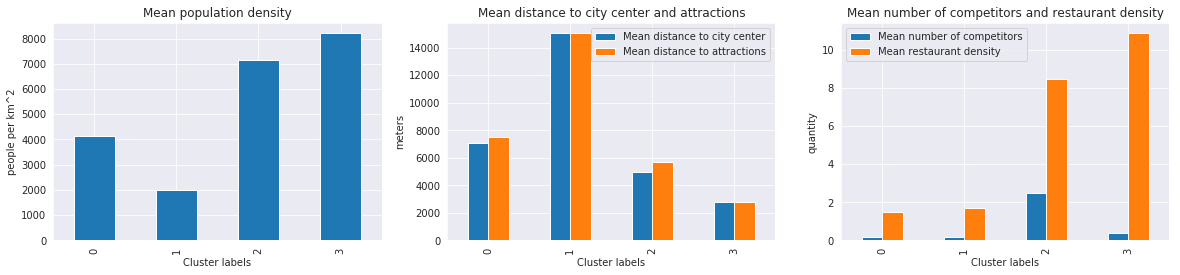

In [247]:
#Displaying means of clusters on key decision variables
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
feature_table['Mean population density'].plot(kind='bar', title='Mean population density', ax=ax1)
feature_table[['Mean distance to city center','Mean distance to attractions']].plot(kind='bar',title='Mean distance to city center and attractions', ax=ax2)
feature_table[['Mean number of competitors','Mean restaurant density']].plot(kind='bar',title='Mean number of competitors and restaurant density', ax=ax3)
ax1.set_ylabel('people per km^2')
ax2.set_ylabel('meters')
ax3.set_ylabel('quantity')

In [248]:
# Identification of optimal cluster for potential locations
print('Identifying optimal cluster')
print('---------------------------')

optimal_cluster = []

value = round(feature_table['Mean population density'].max(),2)
name = feature_table[feature_table['Mean population density']== feature_table['Mean population density'].max()].index.values[0]
print(f'Cluster based on mean population density is cluster {name} with {value} population density')
optimal_cluster.append(name)

value = round(feature_table['Mean distance to city center'].min(),2)
name = feature_table[feature_table['Mean distance to city center']== feature_table['Mean distance to city center'].min()].index.values[0]
print(f'Cluster based on Mean distance to city center is cluster {name} with {value} meters')
optimal_cluster.append(name)

value = round(feature_table['Mean number of competitors'].max(),2)
name = feature_table[feature_table['Mean number of competitors']== feature_table['Mean number of competitors'].max()].index.values[0]
print(f'Cluster based on Mean number of competitors is cluster {name} with {value} competitors')
optimal_cluster.append(name)

value = round(feature_table['Mean restaurant density'].max(),2)
name = feature_table[feature_table['Mean restaurant density']== feature_table['Mean restaurant density'].max()].index.values[0]
print(f'Cluster based on Mean restaurant density is cluster {name} with {value} restaurants')
optimal_cluster.append(name)

value = round(feature_table['Mean distance to attractions'].min(),2)
name = feature_table[feature_table['Mean distance to attractions']== feature_table['Mean distance to attractions'].min()].index.values[0]
print(f'Cluster based on Mean distance to attractions is cluster {name} with {value} meters')
optimal_cluster.append(name)

print('---------------------------')
import statistics
cluster = statistics.mode(optimal_cluster)
print('Optimal cluster is cluster',cluster)

Identifying optimal cluster
---------------------------
Cluster based on mean population density is cluster 3 with 8204.62 population density
Cluster based on Mean distance to city center is cluster 3 with 2785.38 meters
Cluster based on Mean number of competitors is cluster 2 with 2.5 competitors
Cluster based on Mean restaurant density is cluster 3 with 10.88 restaurants
Cluster based on Mean distance to attractions is cluster 3 with 2798.0 meters
---------------------------
Optimal cluster is cluster 3


In [249]:
# Displaying optimal cluster locations and addresses together with key feature values
df_final_table[df_final_table['Cluster labels']==cluster][['Neighborhood',
                                                           'Neighborhood center',
                                                           'Population density',
                                                           'Distance to city center',
                                                          'Competitor',
                                                          'Total restaurants',
                                                          'Median distance to attractions']].sort_values(by='Neighborhood')

,Neighborhood,Neighborhood center,Population density,Distance to city center,Competitor,Total restaurants,Median distance to attractions
0,Altstadt,"Römerberg 16, 60311 Frankfurt am Main, Germany",8187,2792,0.0,7.0,2424.0
2,Bahnhofsviertel,"Jürgen-Ponto-Platz 2, 60329 Frankfurt am Main,...",6558,2383,1.0,12.0,2405.5
8,Bornheim,"Im Prüfling 63, 60389 Frankfurt am Main, Germany",10959,4065,1.0,13.0,4500.5
1,Innenstadt,"Kaiserstraße 19-21, 60311 Frankfurt am Main, G...",4430,1698,0.0,8.0,1811.5
6,Nordend-Ost,"Rothschildallee 20, 60389 Frankfurt am Main, G...",15031,2880,1.0,9.0,3288.5
7,Ostend,"Hanauer Landstraße 89, 60314 Frankfurt am Main...",5246,3160,0.0,10.0,3026.0
12,Sachsenhausen-N,"Stegstraße 77, 60594 Frankfurt am Main, Germany",7676,2982,0.0,14.0,2428.0
3,Westend-South,"Bockenheimer Landstraße 69, 60325 Frankfurt am...",7550,2323,0.0,14.0,2500.0


### Conclusion<a name='conclusion'></a>

In this study, I used clustering analysis to solve a specific spatial problem for stakeholders. I used data science methodology and tools to come up with a manageable list of potential locations in Frankfurt that will be suitable to open an Uzbek restaurant. 45 neighborhoods were analyzed based on five decision variables, namely population density of neighborhoods, distance of neighborhoods to the city center, median distance of neighborhoods to top 100 tourist attractions, the number of restaurants within 500 m radius of a neighborhood center and the number of potential competitors in those areas. These five key variables were calculated using data from various open sources and used in k-Means clustering that divided neighborhoods into 4 clusters. These clusters were labeled based on key characteristics and one cluster was chosen to come up with potential locations to open an Uzbek restaurant in Frankfurt. A table of 8 potential locations with addresses was presented for stakeholders, which can help them to save resources in finding a suitable place.